# Импорты

In [4]:
!pip -q install -U transformers datasets evaluate accelerate

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
import numpy as np
from datasets import load_dataset
import re
from collections import Counter
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
import transformers



os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.set_float32_matmul_precision("high")
torch.backends.cudnn.benchmark = True 

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
pl.seed_everything(42)

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Seed set to 42


PyTorch version: 2.9.1+cu126
PyTorch Lightning version: 2.6.0
CUDA available: True


## RoBERTa

In [12]:
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import transformers

print("transformers:", transformers.__version__)

ds = load_dataset("ag_news")
split = ds["train"].train_test_split(test_size=0.1, seed=42, stratify_by_column="label")
train_ds = split["train"]
val_ds   = split["test"]
test_ds  = ds["test"]

model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

MAX_LEN = 256
def tok(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=MAX_LEN)

train_ds = train_ds.map(tok, batched=True)
val_ds   = val_ds.map(tok, batched=True)
test_ds  = test_ds.map(tok, batched=True)

train_ds = train_ds.rename_column("label", "labels")
val_ds   = val_ds.rename_column("label", "labels")
test_ds  = test_ds.rename_column("label", "labels")

cols = ["input_ids", "attention_mask", "labels"]
train_ds.set_format(type="torch", columns=cols)
val_ds.set_format(type="torch", columns=cols)
test_ds.set_format(type="torch", columns=cols)

metric_f1 = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"macro_f1": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"]}

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

args = TrainingArguments(
    output_dir="./agnews_roberta_base",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,                 
    per_device_train_batch_size=8,      
    gradient_accumulation_steps=2,      
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    weight_decay=0.01,
    warmup_ratio=0.06,
    lr_scheduler_type="cosine",
    label_smoothing_factor=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    fp16=True,
    logging_steps=100,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=tokenizer,  
    compute_metrics=compute_metrics,
)

trainer.train()
print("VAL:", trainer.evaluate(val_ds))
print("TEST:", trainer.evaluate(test_ds))


transformers: 4.57.3


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

C:\Users\arsen\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\arsen\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1
1,0.489000,0.478961,0.943083
2,0.448900,0.479528,0.944453
3,0.443500,0.478695,0.946077
4,0.410900,0.484339,0.946252


VAL: {'eval_loss': 0.48433926701545715, 'eval_macro_f1': 0.946252154548978, 'eval_runtime': 17.8693, 'eval_samples_per_second': 671.542, 'eval_steps_per_second': 10.521, 'epoch': 4.0}
TEST: {'eval_loss': 0.4694676995277405, 'eval_macro_f1': 0.9527658975860256, 'eval_runtime': 11.5288, 'eval_samples_per_second': 659.216, 'eval_steps_per_second': 10.322, 'epoch': 4.0}


## Оценка

### На тестовом датасете

In [16]:
print("TEST:", trainer.evaluate(test_ds))

TEST: {'eval_loss': 0.4694676995277405, 'eval_macro_f1': 0.9527658975860256, 'eval_runtime': 10.5774, 'eval_samples_per_second': 718.51, 'eval_steps_per_second': 11.25, 'epoch': 4.0}


### Матрица

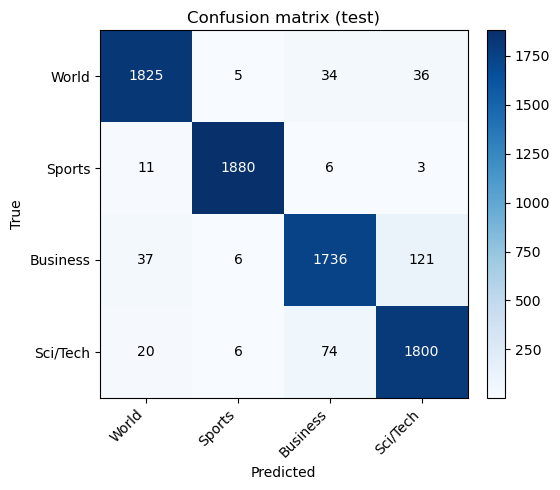

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

pred_out = trainer.predict(test_ds)
y_pred = np.argmax(pred_out.predictions, axis=1)
y_true = pred_out.label_ids

labels = ["World", "Sports", "Business", "Sci/Tech"]
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap="Blues")

ax.set_title("Confusion matrix (test)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels)

thresh = cm.max() * 0.5
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, str(cm[i, j]),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
